# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

In [60]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math

In [22]:
# read data
path = "./data/AMAZON_FASHION_5.json"

data = pd.read_json(path, lines = True)

In [23]:
# get first look
print(f"Data has {len(data)} datapoints.")
print(f"Data has {len(data.columns)} Columns.")

print("Columns:")
print(list(data.columns))

Data has 3176 datapoints.
Data has 12 Columns.
Columns:
['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image']


In [24]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [25]:
# drop unnedded columns
columns_keep = ["overall", "reviewText", "summary"]
drop_columns = [i for i in list(data.columns) if i not in columns_keep]

data.drop(drop_columns, axis=1, inplace=True)

# drop nan
print(len(data))
data = data.dropna()
print(len(data))

3176
3160


Most saved rating is 5 with 2142 datapoints.
Least saved rating is 2 with 93 datapoints.


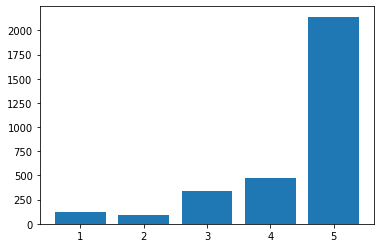

In [26]:
# how many datapoints per rating
rating_count = {}
all_ratings = sorted(data["overall"].unique())


for rating in all_ratings:
    
    rating_count[rating] = len(data[data["overall"] == rating])

# data information
most_rated = max(rating_count, key = rating_count.get)
least_rated = min(rating_count, key = rating_count.get)
print(f"Most saved rating is {most_rated} with {rating_count[most_rated]} datapoints.")
print(f"Least saved rating is {least_rated} with {rating_count[least_rated]} datapoints.")

# show graph
plt.bar(list(rating_count.keys()), list(rating_count.values()))
plt.show()

-----------

# provisionally Conclusion

Sample Data is highly imbalanced.

For now there should be used a sub_dataset with evenly distributed data.

This effect should be considered when using whole dataset

------------

In [73]:
# create balanced dataset by min count class (function from: https://stackoverflow.com/questions/45839316/pandas-balancing-data)
data_balanced = data[data["overall"] == least_rated]
remain_ratings = [i for i in all_ratings if i != least_rated]


for remain_rating in remain_ratings:
    
    # append data
    data_balanced = data_balanced.append(data[data["overall"] == remain_rating][:rating_count[least_rated]])

# reset index
data_balanced = data_balanced.reset_index(drop = True)

In [74]:
# vectorize all tetxs
## use tf and idf functions of Document finding (previous Lecture)

def check_word(word):
    "Check if word is valid due to some restrictions"
    
    exception_list = ["\n"]
    
    for element in exception_list:
        
        if element in word:
            
            return False
    
    if len(word) < 4:
        
        return False
    
    if word.isalpha():
    
        return True
    
    else:
        
        return False

def create_tf_vector(data):
    "Create tf_vector as dict"
    
    words = data.split(" ")
    
    tmp_dict = {}
    
    count = 0
        
    for word in words:
        
        word = word.lower()
        
        if check_word(word):
            
            count += 1

            if word in tmp_dict.keys():

                tmp_dict[word] += 1

            else:

                tmp_dict[word] = 1
    
    for key in tmp_dict.keys():
        
        tmp_dict[key] = tmp_dict[key] / count
    
    return tmp_dict

def create_tf_vector_all_reviews(dataframe, column = "reviewText"):
    "create a dictionary for each review with the corresponding tf as value"

    # initialize variables
    index = 0
    tf_dict = {}
    
    # get all reviewTexts
    reviewTexts = list(data_balanced[column])
    
    # create tf dicts
    for element in reviewTexts:
        
        tf_dict[index] = create_tf_vector(element)
        index += 1
    
    return tf_dict

def create_idf_dictionary(tf_dict):

    # create idf dictionary

    idf_dict = {}

    document_count = 0

    for review_dict in tf_dict.keys():

        document_count += 1
        
        key_list = list(tf_dict[review_dict].keys())

        for list_word in key_list:

            if list_word in idf_dict:

                idf_dict[list_word] += 1

            else:

                idf_dict[list_word] = 1


    for key in idf_dict.keys():

        idf_dict[key] = math.log(document_count / idf_dict[key])
    
    return idf_dict

def create_word_vector(idf_dict, tf_dict):
    
    tmp_word_vec_dict = {}
    
    for idf in idf_dict.keys():
            
            if idf in tf_dict.keys():
                
                tmp_word_vec_dict[idf] = tf_dict[idf] * idf_dict[idf]
            
            else:
                
                tmp_word_vec_dict[idf] = 0
    
    sorted_word_vec = dict(sorted(tmp_word_vec_dict.items()))
    
    return sorted_word_vec

def create_word_vector_dict(review_dict, idf_dict):

    word_vector_dict_textual = {} # can be depriciated lateron
    word_vector_dict_array = {}

    for review_index in review_dict.keys():

            word_vector_dict_textual[review_index] = create_word_vector(idf_dict, review_dict[review_index]) # can be depriciated lateron
            word_vector_dict_array[review_index] = np.array(
                pd.Series(
                    create_word_vector(idf_dict, review_dict[review_index])
                )
            )
    
    return word_vector_dict_array

In [101]:
# create review_dict
review_dict = create_tf_vector_all_reviews(data_balanced)

# create idf dict
idf_dict = create_idf_dictionary(tf_dict)

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict)

# include word_vec_dict in dataframe
data_balanced["word_vectors"] = word_vec_dict.values()

In [103]:
# get a look at the data
data_balanced.head()

,overall,reviewText,summary,word_vectors
0,2,Relieved my Plantar Fascitis for 3 Days. Then ...,These were recommended by my Podiatrist,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,This is my 6th pair and they are the best thin...,Not the same as all my other pairs.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,Relieved my Plantar Fascitis for 3 Days. Then ...,These were recommended by my Podiatrist,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,This is my 6th pair and they are the best thin...,Not the same as all my other pairs.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,Nice pants but too small for a medium. Return it.,Returned also,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [104]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data_balanced,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data_balanced["overall"]
                                        )

-------

# Now start Sentiment analysis

-------

In [ ]:
# now implement naive bayes

In [105]:
train_data.head()

,overall,reviewText,summary,word_vectors
441,5,The color pattern and fit is what I liked the ...,The color pattern and fit is what I liked the ...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
318,4,I have had this style before in a different co...,Love these shoes,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.2791835184357889, ..."
433,5,"Well made, soft, thick & so very colorful. Bou...","Well made, soft, thick & so very colorful ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
186,3,Waaay too small. Will use for futur children!,Oops!,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
185,1,Artculo equivocado en color,One Star,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
